Есть такой сайт IPUMS, который под покровительством университета Миннесоты занимается сбором, обработкой и публикацией данных различных переписей населения. Фишка в том, что там есть данные по каждому респонденту переписи по многим вопросам (от наличия стиральной машины в домохозяействе до уровня образования и количества детей респондента). По этим данным можно выявлять довольно интересные и неочевидные закономерности, поэтому давайте попробуем обучить на этих данных какие-нибудь ML модели.

Для начала, давайте возьмём данные переписи США 2015 года. В вопросном листе этой переписи присутствовали вопросы об уровне годового дохода. Давайте попробуем предсказывать уровень дохода человека, основываясь на каких-нибудь других признаках (например, уровень образования, пол, семейное положение)

## Работа с данными

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
random_state = 9

In [3]:
df_dem = pd.read_csv('https://github.com/AleksVart/AndanProject/raw/main/US_2015.csv', sep = ';')

In [4]:
df_dem.describe()

,US2015A_EDUC,US2015A_INCTOT,US2015A_SEX,US2015A_AGE,US2015A_NCHILD,US2015A_MARST,US2015A_UHRSWORK
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,6.309909e+01,1.719956e+06,1.511336e+00,4.102650e+01,5.002170e-01,3.648573e+00,1.898217e+01
std,3.259213e+01,3.731263e+06,4.998717e-01,2.353541e+01,9.482776e-01,2.302782e+00,2.115208e+01
min,1.000000e+00,-1.120000e+04,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+01,9.600000e+03,1.000000e+00,2.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00
50%,6.400000e+01,3.000000e+04,2.000000e+00,4.200000e+01,0.000000e+00,4.000000e+00,0.000000e+00
75%,8.100000e+01,9.000000e+04,2.000000e+00,6.000000e+01,1.000000e+00,6.000000e+00,4.000000e+01
max,1.160000e+02,9.999999e+06,2.000000e+00,9.700000e+01,9.000000e+00,6.000000e+00,9.900000e+01


In [5]:
df_dem.columns = ['EDUC','INCTOT','SEX', 'AGE', 'NCHILD', 'MARST', 'UHRSWORK' ] # Столбцы: уровень образования(зашифрован), годовой доход, пол, кол-во детей, семейное положение(зашифровано), время работы/месяц

In [6]:
df_dem

,EDUC,INCTOT,SEX,AGE,NCHILD,MARST,UHRSWORK
0,50,3450,1,56,0,1,5
1,71,14000,2,61,0,1,0
2,15,9999999,2,8,0,6,0
3,71,35000,1,61,0,4,40
4,26,8800,2,52,0,4,0
...,...,...,...,...,...,...,...
1048570,50,0,1,18,0,6,0
1048571,65,21400,1,61,1,1,20
1048572,81,54000,2,50,1,1,40
1048573,63,17900,1,19,0,6,29


Код 1 в графе "уровень образования" обозначает - NIU (not in universe), то есть, респондент не подходит под критерии выборки(например, так как младше 3х лет). Данные по этим респондентам нам ни к чему. Удалим их.

In [7]:
len(df_dem[df_dem['EDUC']== 1]) # Нашли число респондентов, для которых уровень образования не определён

31647

Так как респондентов с неопределённым уровнем образования оказалось всего 31647 (из более чем миллиона респондентов), удалим данные по этим респондентам.

In [8]:
df_dem = df_dem.drop(df_dem[df_dem['EDUC']== 1].index, axis = 0)

In [9]:
df_dem[df_dem['EDUC']== 1]

,EDUC,INCTOT,SEX,AGE,NCHILD,MARST,UHRSWORK


Теперь почистим данные о доходах. Доход обозначается числом долларов, заработанным в год. Кроме того кодом кодом 9999999 обозначаются данные по доходам респондентов, не подходящие под выборку (младше 15 лет).

In [10]:
len(df_dem[df_dem['INCTOT']== 9999999])

145313

In [11]:
len(df_dem[(df_dem['INCTOT']== 9999999) & (df_dem['AGE'] < 15)])

145313

Видим, что все респонденты со значением 9999999 в графе "доход" - младше 15 лет. То есть, можно спокойно удалить эти данные из таблицы, не боясь случайно убрать оттуда людей, в самом деле, имеющий годовой доход от 10 миллионов $, если такие каким-то образом оказались бы в таблице.

In [12]:
df_dem = df_dem.drop(df_dem[(df_dem['INCTOT']== 9999999)].index, axis = 0)

In [13]:
len(df_dem[(df_dem['INCTOT']== 9999999) & (df_dem['AGE'] < 15)])

0

In [15]:
df_dem

,EDUC,INCTOT,SEX,AGE,NCHILD,MARST,UHRSWORK
0,50,3450,1,56,0,1,5
1,71,14000,2,61,0,1,0
3,71,35000,1,61,0,4,40
4,26,8800,2,52,0,4,0
5,101,13200,1,84,0,5,0
...,...,...,...,...,...,...,...
1048570,50,0,1,18,0,6,0
1048571,65,21400,1,61,1,1,20
1048572,81,54000,2,50,1,1,40
1048573,63,17900,1,19,0,6,29


Теперь заменим закодированный уровень образования на среднее число лет, необходимое для его получения. Таким образом, мы сможем потом обучить по этим данным линейную регрессию. 

2	No schooling completed	0

11	Nursery school, preschool	0

12	Kindergarten	0

14	Grade 1	1

15	Grade 2	2

16	Grade 3	3

17	Grade 4	4

22	Grade 5	5

23	Grade 6	6

25	Grade 7	7

26	Grade 8	8

30	Grade 9	9

40	Grade 10	10

50	Grade 11	11

61	12th grade, no diploma	12

63	Regular high school diploma	12

64	GED or alternative credential	12

65	Some college, but less than 1 year	12,5

71	1 or more years of college credit, no degree	13,5

81	Associate's degree, type not specified	14

101	Bachelor's degree	16

114	Master's degree	18

115	Professional degree beyond a bachelor's degree	19

116	Doctoral degree	23,5

In [16]:
df_dem['EDUC'] = df_dem['EDUC'].replace([2,11,12,14,15,16,17,22,23,25,26,30,40,50,61,63,64,65,71,81,101,114,115,116], [0,0,0,1,2,3,4,5,6,7,8,9,10,11,12,12,12,12.5,13.5,14,16,18,19,23.5])

## Некоторые картинки

Посмотрим на расапределение людей, по кол-ву лет учёбы:

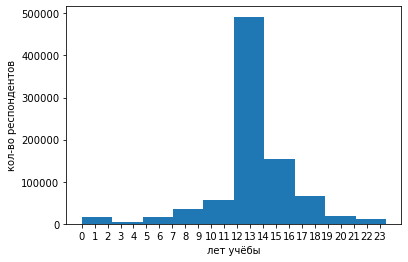

In [24]:
plt.hist(df_dem['EDUC'], bins = 10 )
plt.xlabel('лет учёбы')
plt.ylabel('кол-во респондентов')
plt.xticks(np.arange(0, 23.5, 1.0));

Посмотри теперь на эти же данные, но разделим людей по полу

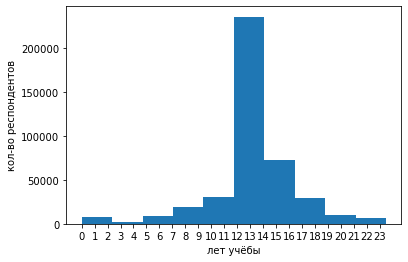

In [25]:
plt.hist(df_dem[df_dem['SEX'] == 1]['EDUC'], bins = 10 ) # Мужчины
plt.xlabel('лет учёбы')
plt.ylabel('кол-во респондентов')
plt.xticks(np.arange(0, 23.5, 1.0));

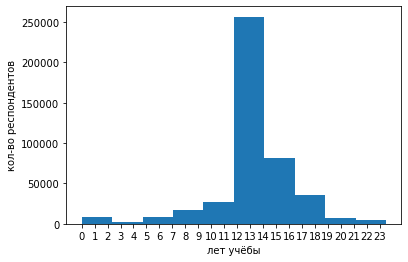

In [26]:
plt.hist(df_dem[df_dem['SEX'] == 2]['EDUC'], bins = 10 ); #Женщины
plt.xlabel('лет учёбы')
plt.ylabel('кол-во респондентов')
plt.xticks(np.arange(0, 23.5, 1.0));

Распределения выглядят похоже для обоих полов

Посмотрим на средний доход для разного количества лет учёбы

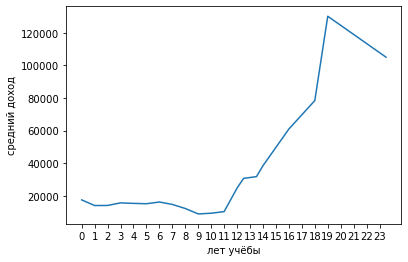

In [39]:
plt.plot(df_dem[['EDUC','INCTOT']].groupby(by = 'EDUC').mean())
plt.xticks(np.arange(0, 23.5, 1.0))
plt.xlabel('лет учёбы')
plt.ylabel('средний доход');

Получившуюся картину можно интерпретировать так: 
>Без школьного образования - самый низкий доход, почти не зависящий от количества лет учёбы.

>Окончание школы(12 лет) даёт значительный прирост дохода.

>Даже неоконченное университетсткое образование, в среднем, соотносится с кратным ростом дохода.

>Наибольший доход имеют респонденты, обладающие Магистерской(примерно, 18 лет учёбы суммарно) или профессиональной степенью(Professional degree beyond a bachelor's degree) - примерно, 19 лет учёбы суммарно.

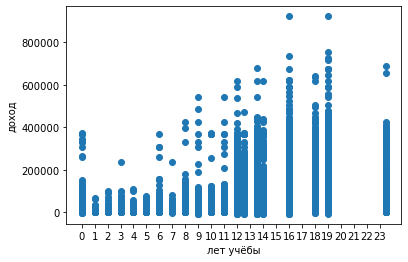

In [41]:
plt.scatter(df_dem['EDUC'].iloc[0:100000], df_dem['INCTOT'].iloc[0:100000]) # Диаграмма рассеивания доход/ лет учёбы
plt.xlabel('лет учёбы')
plt.ylabel('доход')
plt.xticks(np.arange(0, 23.5, 1.0));

Большой разброс в доходах

Теперь глянем на то, как ведёт себя доход при разном уровне образования в зависимости от пола

In [53]:
df_dem_m = df_dem[df_dem['SEX']==1] # Мужчины
df_dem_f = df_dem[df_dem['SEX']== 2] # Женщины
m_earns = df_dem_m[['EDUC','INCTOT']].groupby(by = 'EDUC').mean()# Средние доходы мужчин
f_earns = df_dem_f[['EDUC','INCTOT']].groupby(by = 'EDUC').mean()# Средние доходы женщин

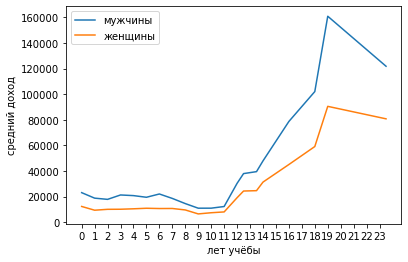

In [54]:
plt.plot(m_earns)
plt.plot(f_earns)
plt.xticks(np.arange(0, 23.5, 1.0))
plt.xlabel('лет учёбы')
plt.ylabel('средний доход')
plt.legend(['мужчины', 'женщины']);

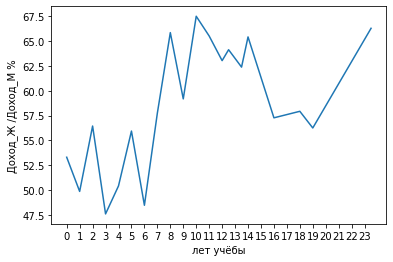

In [57]:
plt.plot(100*(f_earns/m_earns))
plt.xticks(np.arange(0, 23.5, 1.0))
plt.xlabel('лет учёбы')
plt.ylabel('Доход_Ж /Доход_М %'); # Доходы женщин к доходам мужчин в впроцентах

>Женщины, в среднем, на каждом уровне образования получают меньший доход.

>Причём наибольшая процентная разница наблюдается среди респондентов с низким уровнем образования (6 и меньше классов школы)

>Наиболее близки к паритету доходы окончивших школу

>У бакалавров и магистров процентная разница вновь возрастает

>На уровне PhD соотношение зарплат стремиться к сокращению разрыва

## Попробуем пострить регрессию

Попробуем проверить гипотезу, например, о том, что люди, например, имеющие бакалаврское образование получают значительно больший( например на 50%) доход, чем люди только со школьным образованием. 

Будем анализировать зрелых(уже  окончивших свою учёбу респондентов: > 30 лет)

In [42]:
df_dem_star = df_dem[(df_dem['AGE']>=30) & (df_dem['AGE']< 75) ]

In [43]:
df_inc_edu = df_dem_star[['EDUC','INCTOT']]

In [44]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_inc_edu,test_size =  0.2)

In [45]:
df_test

,EDUC,INCTOT
964179,16.0,18000
36903,14.0,93500
911632,12.0,54400
684810,18.0,97004
656688,18.0,0
...,...,...
28373,14.0,33000
39425,12.0,19000
755431,16.0,81000
21185,10.0,9600


In [46]:
x_train = df_train['EDUC'].to_numpy().reshape(-1,1)
y_train = df_train['INCTOT'].to_numpy().reshape(-1,1)
x_test = df_test['EDUC'].to_numpy().reshape(-1,1)
y_test = df_test['INCTOT'].to_numpy().reshape(-1,1)

In [47]:
from sklearn.linear_model import LinearRegression
model_basic_linear = LinearRegression()

In [48]:
model_basic_linear.fit(x_train,y_train)

LinearRegression()

In [49]:
predict_basic_linear = model_basic_linear.predict(x_test)

In [50]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

In [51]:
print('MAPE = ',mean_absolute_percentage_error(predict_basic_linear,y_test), '\n')
print('MSE = ', mean_squared_error(predict_basic_linear,y_test), '\n')
print('MAE = ', mean_absolute_error(predict_basic_linear,y_test))

MAPE =  0.9049094349012836 

MSE =  4217812295.294886 

MAE =  36792.52669142882


In [52]:
model_basic_linear.coef_

array([[6123.12590644]])

In [53]:
model_basic_linear.intercept_

array([-35304.12400141])

Text(0, 0.5, 'доход')

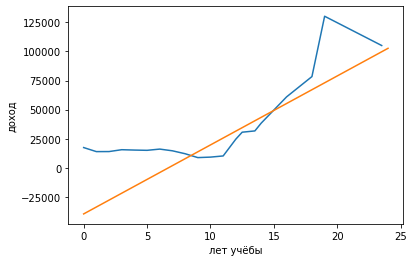

In [66]:
plt.plot(df_dem[['EDUC','INCTOT']].groupby(by = 'EDUC').mean()) # Средний доход от лет учёбы
plt.plot(np.linspace(0,24,100),5921.44533212*np.linspace(0,24,100) -39475.8087161)
plt.xlabel('лет учёбы')
plt.ylabel('доход')


Попробуем добавить в модель квадратичную фукцию

In [268]:
from sklearn.preprocessing import PolynomialFeatures

In [269]:
poly = PolynomialFeatures(2)


In [270]:
len(df_dem_star['INCTOT'][df_dem_star['INCTOT'] == 0])

60787

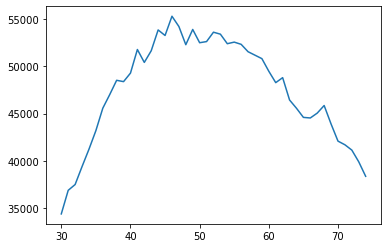

In [271]:
plt.plot(df_dem_star[['AGE', 'INCTOT']].groupby(by ='AGE' ).mean())